This notebook contains trend calculations for food_sales and auto_sales. These are a subset of the larger retail_sales dataframe.

## Example - Food Sales

In [58]:
# Set up 
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore") # Ignore warnings to clean up output cell 

# Set matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11,5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10
)
plot_params = dict(
    color="0.75",
    style='.-',
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False
)

%config InlineBackend.figure_format = 'retina'

In [95]:
# Create retail_sales df using sales_url
sales_url = 'https://raw.githubusercontent.com/jimlehner/datasets/main/us-retail-sales.csv'
retail_sales = pd.read_csv(sales_url,
                          parse_dates=['Month'],
                          index_col='Month'
                          ).to_period('M') # Period will affect the time domain of the forecast. If period is set to day (D) the forecast will be at the day level.

# Create food_sales series from retail_sales df
food_sales = retail_sales.loc[:,'FoodAndBeverage']

# Create auto_sales series from retail_sales df
auto_sales = retail_sales.loc[:,'Automobiles']
auto_sales

Month
1992-01     26788
1992-02     28203
1992-03     31684
1992-04     32547
1992-05     32883
            ...  
2019-08    105884
2019-09     91758
2019-10     95219
2019-11     93303
2019-12     96137
Freq: M, Name: Automobiles, Length: 336, dtype: int64

## Determine trend of food_sales with moving average

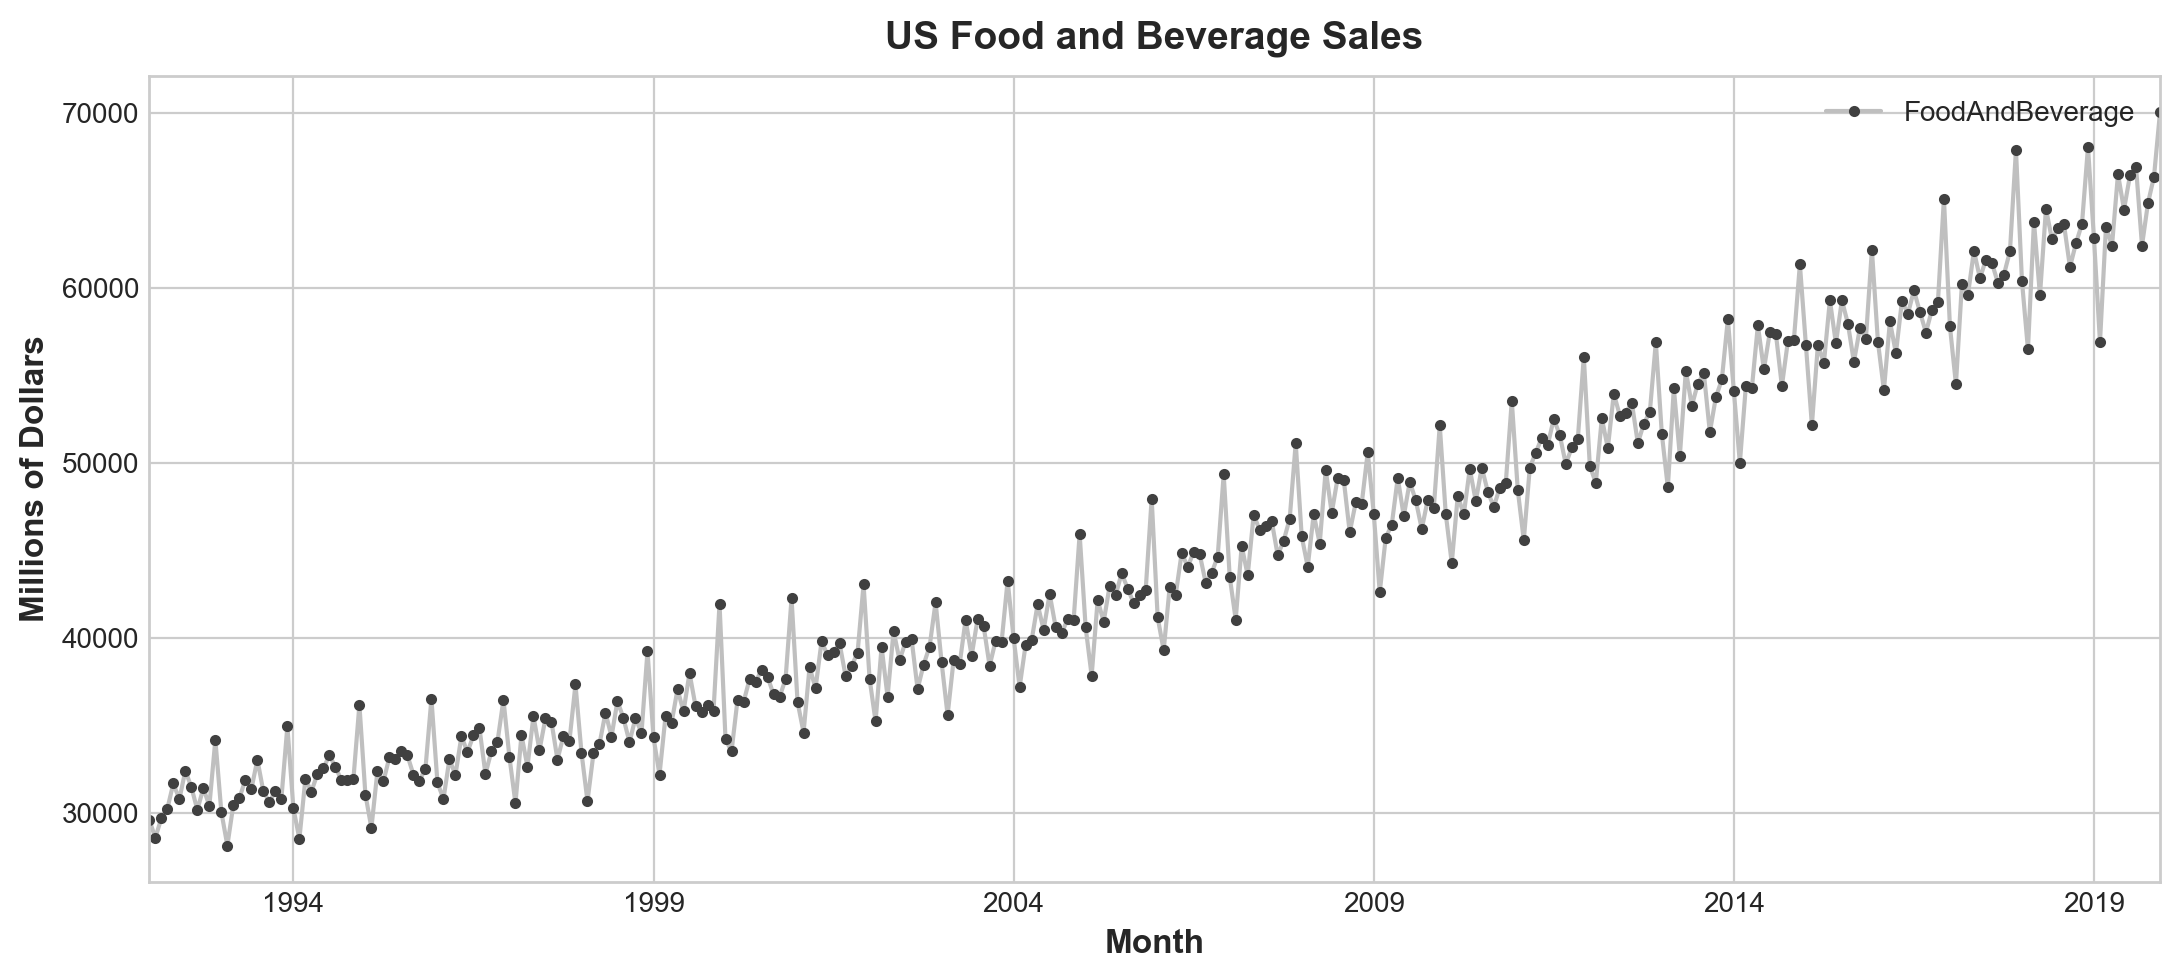

In [86]:
# Start by plotting the data we want to determine the trend of
ax = food_sales.plot(**plot_params)
ax.set(title='US Food and Beverage Sales', 
      ylabel='Millions of Dollars'); # The semi-colon stops the labels from printing seperate from the chart
ax.legend();

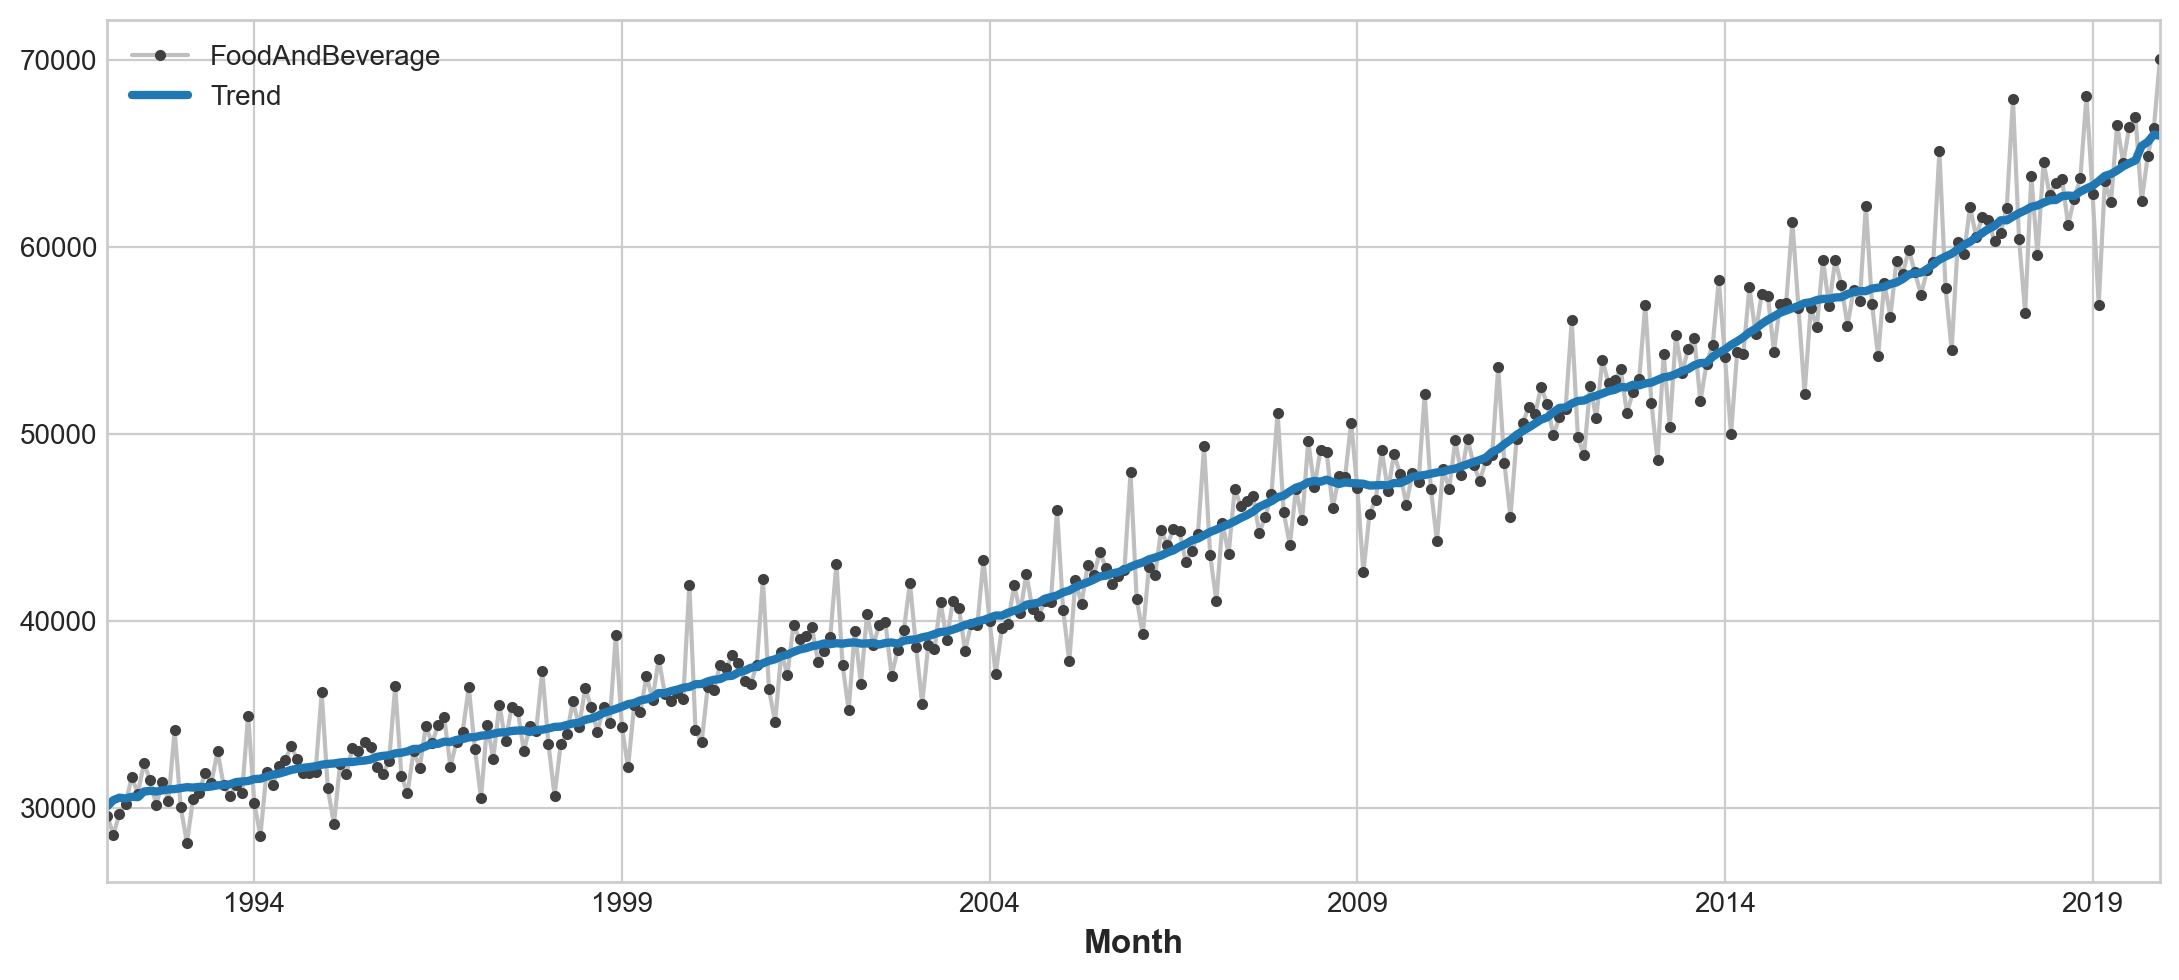

In [87]:
# Create moving_range
moving_average = food_sales.rolling(
    window=12, # 12-month window covers a year
    center=True, # Puts mean at the center of the window
    min_periods=6 # Set to half the window
).mean()

# Plot food_sales and food_sales moving range together
ax = food_sales.plot(**plot_params)
moving_average.plot(ax=ax, linewidth=3, label='Trend')
ax.legend();

## Engineer the time dummy

In [105]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=food_sales.index, # Dates from the training data
    constant=True, # Dummy feature for the bias (y_intercept)
    order=2, # The time dummy (trend)
    drop=True # Drop terms if necessary to avoid collinearity
)

# in_sample creates features for the dates given in the index argument 
X = dp.in_sample()
X.head()

,const,trend,trend_squared
Month,,,
1992-01,1.0,1.0,1.0
1992-02,1.0,2.0,4.0
1992-03,1.0,3.0,9.0
1992-04,1.0,4.0,16.0
1992-05,1.0,5.0,25.0


A deterministic process is a time-series that is non-random or completetly determined. Put more simply, a deterministic process is a time-series that exhibits trend and/or seasonality patterns.

In [106]:
from sklearn.linear_model import LinearRegression
y = food_sales

model = LinearRegression(fit_intercept=False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Month
1992-01    30368.564734
1992-02    30415.636455
1992-03    30463.052190
1992-04    30510.811938
1992-05    30558.915699
               ...     
2019-08    64737.577546
2019-09    64898.517588
2019-10    65059.801644
2019-11    65221.429712
2019-12    65383.401794
Freq: M, Length: 336, dtype: float64

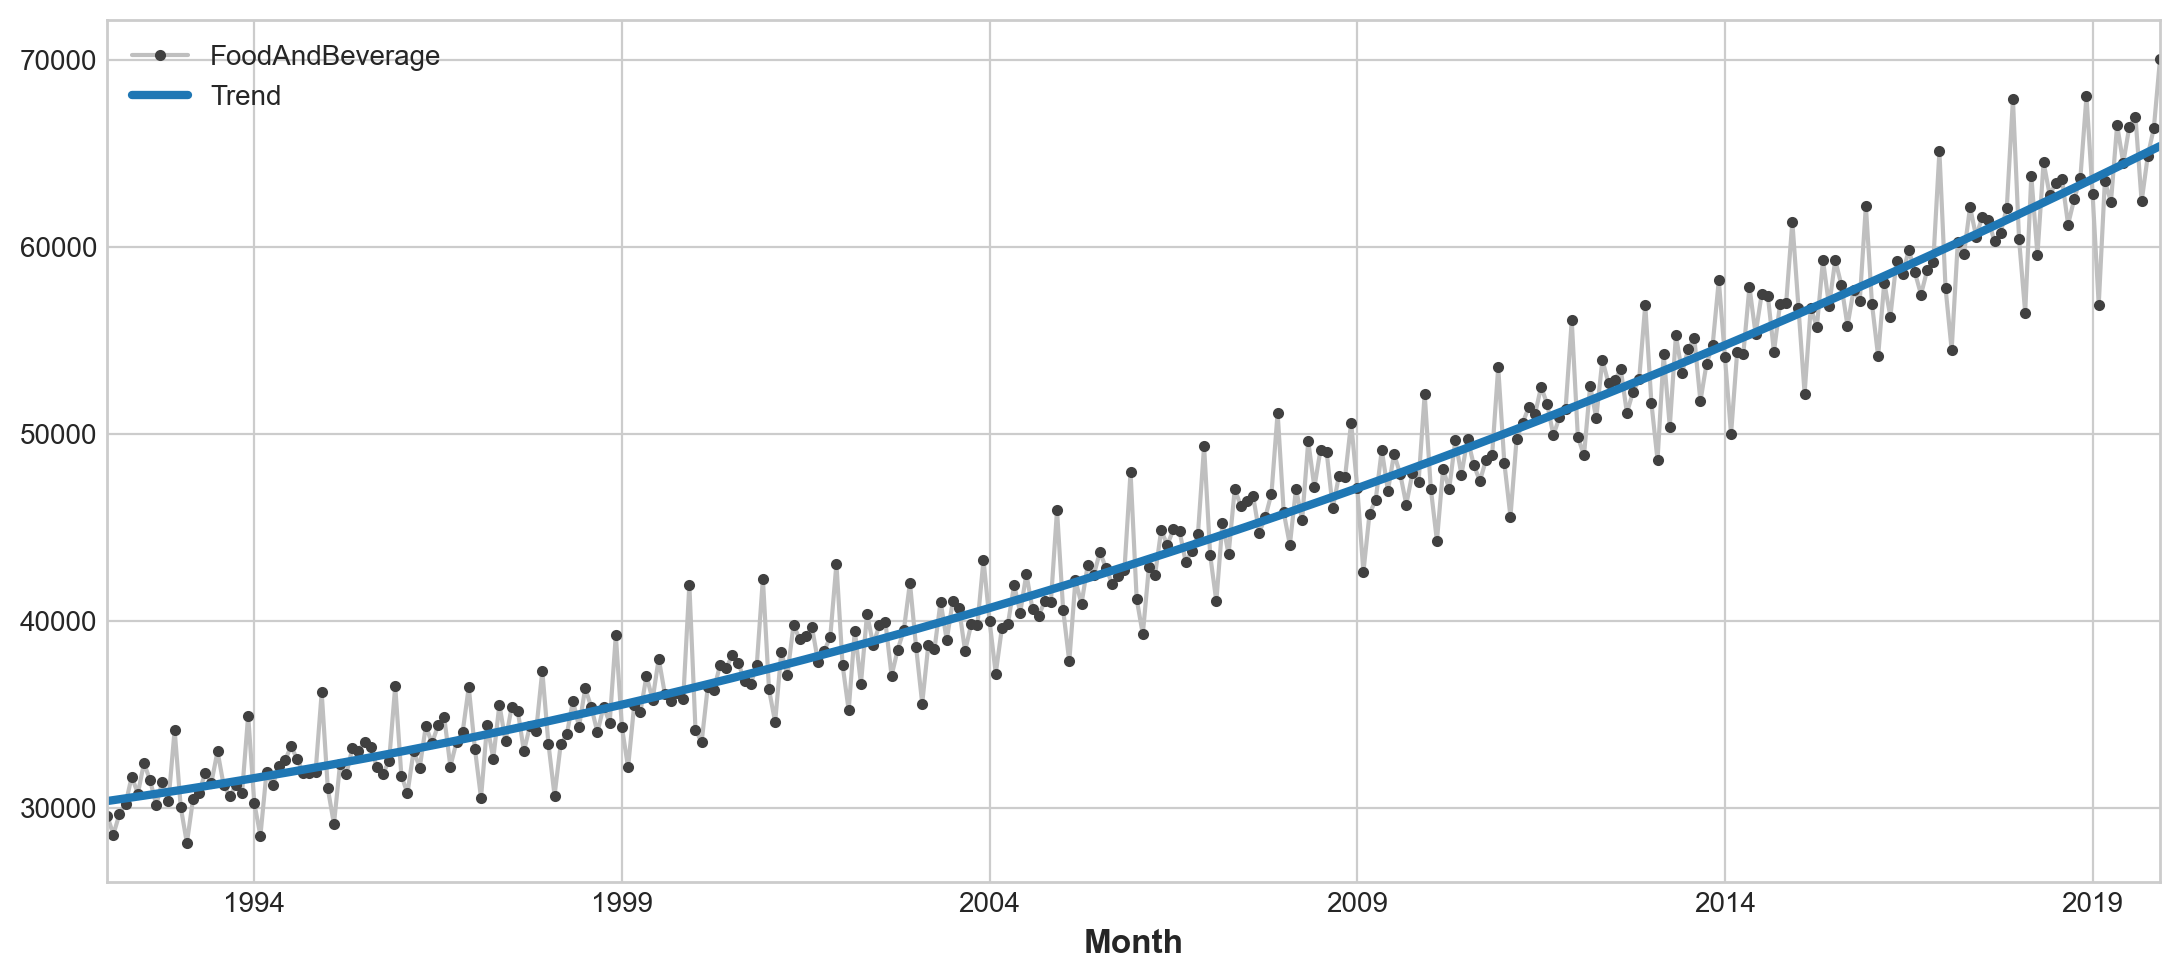

In [107]:
# Plot the food and beverage sales with the LinearRegression model
# The model is set to an order of 2 meaning it is quadratic (parabola)
ax = food_sales.plot(**plot_params)
y_pred.plot(ax=ax,
           linewidth=3,
           label='Trend')
ax.legend();

The trend discovered by the ```LinearRegression``` model is similar to the moving average plot. 

## Make a forecast for food_sales
To make the forecast we apply the model to "out of sample" features.

The forecast we will make is for 30 months "out of sample".

In [91]:
X = dp.out_of_sample(steps=30)
X.head()

,const,trend,trend_squared
2020-01,1.0,337.0,113569.0
2020-02,1.0,338.0,114244.0
2020-03,1.0,339.0,114921.0
2020-04,1.0,340.0,115600.0
2020-05,1.0,341.0,116281.0


In [92]:
# Create the y_fore series
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

2020-01    65545.717889
2020-02    65708.377996
2020-03    65871.382117
2020-04    66034.730251
2020-05    66198.422398
Freq: M, dtype: float64

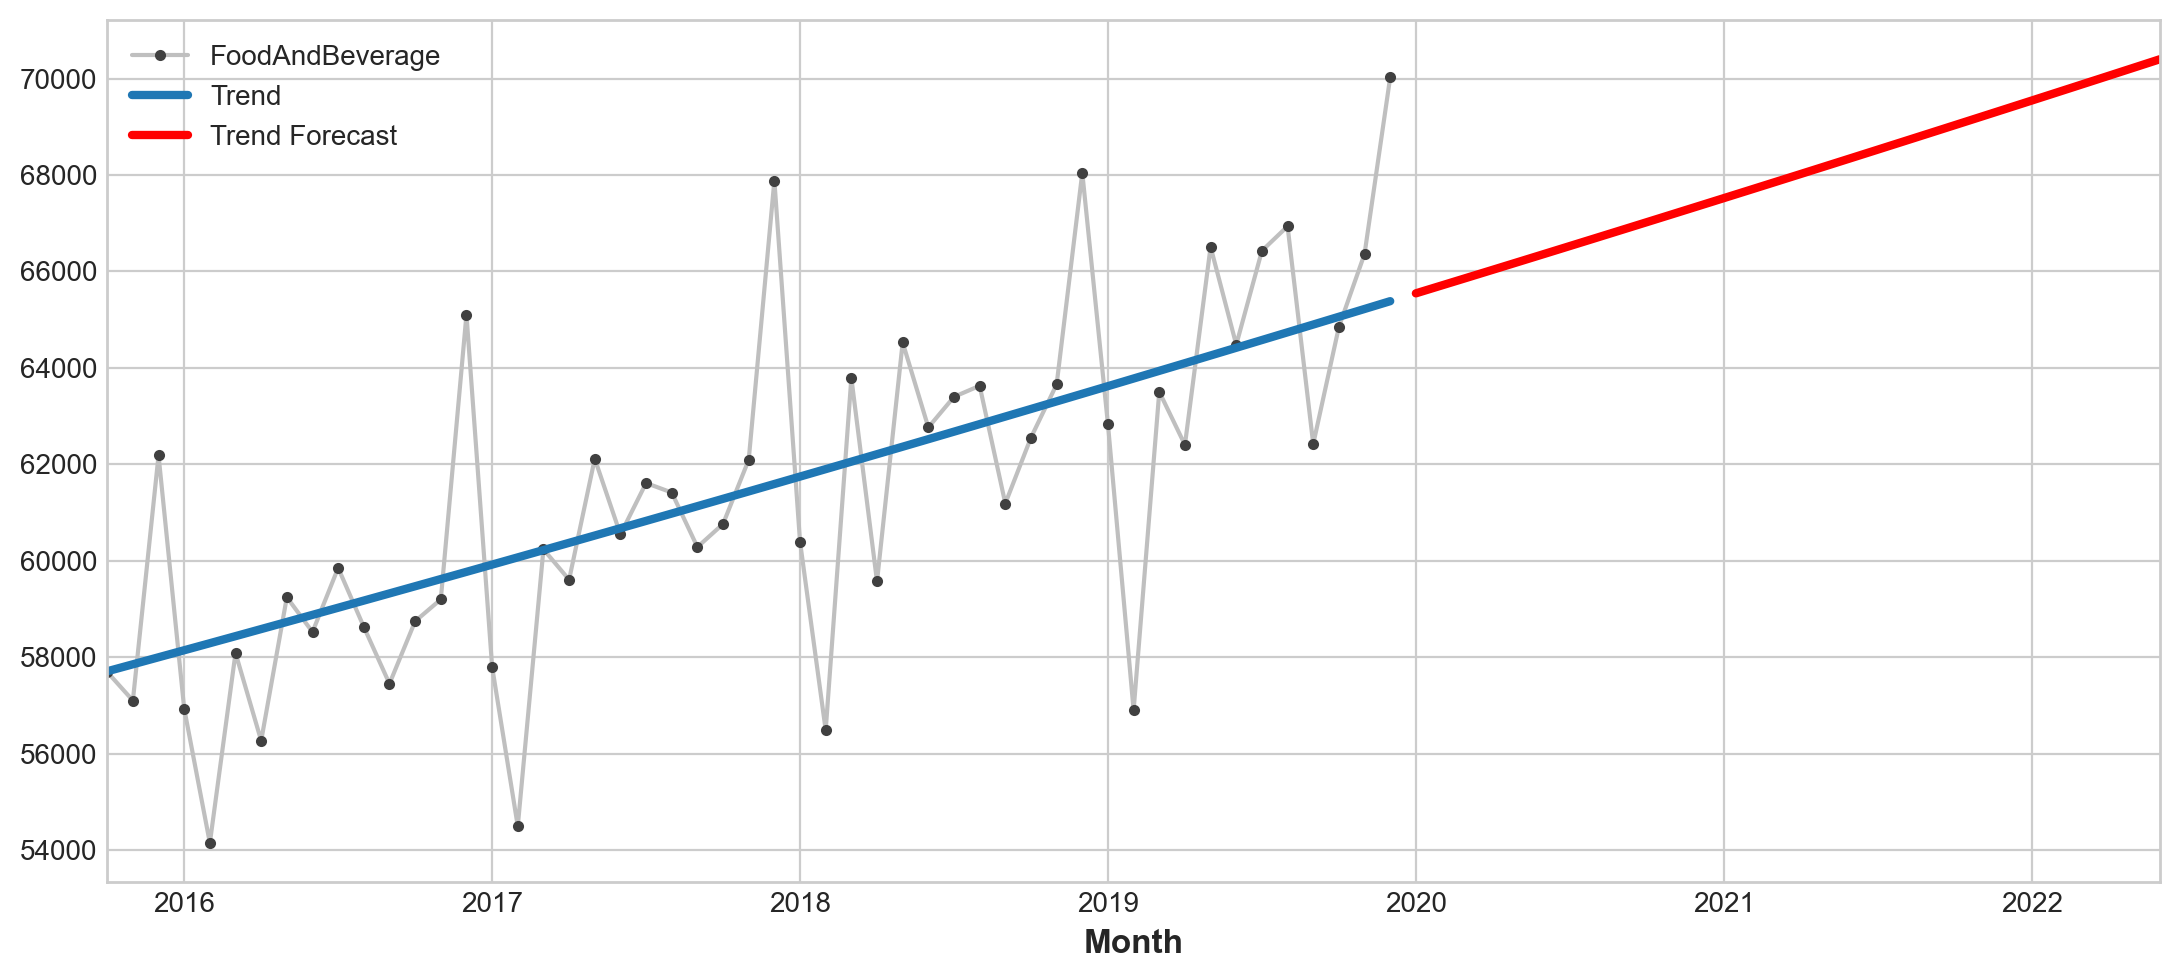

In [93]:
ax = food_sales["2015-10":].plot(**plot_params)
ax = y_pred["2015-10":].plot(ax=ax,
                       linewidth=3,
                       label='Trend')
ax = y_fore["2015-10":].plot(ax=ax,
           linewidth=3, 
           label='Trend Forecast',
           color='red')
ax.legend();

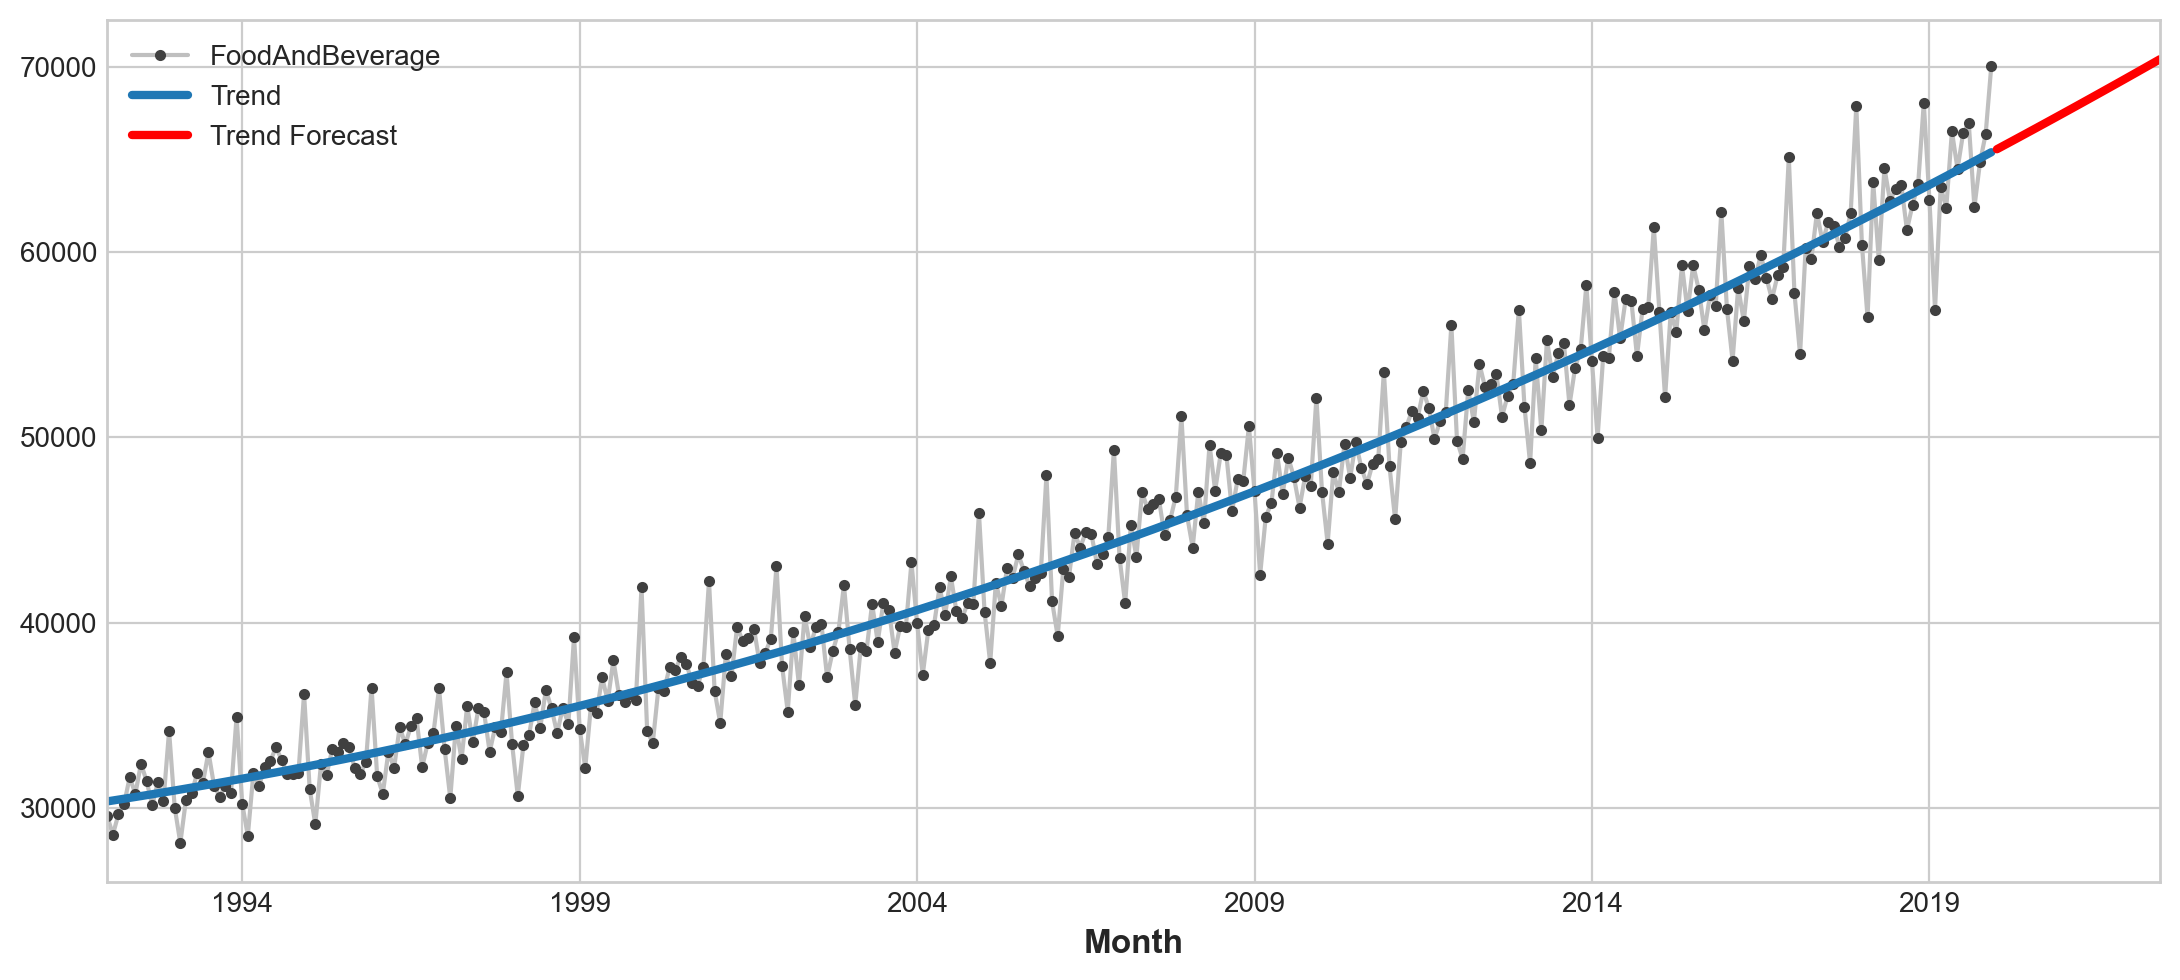

In [94]:
ax = food_sales.plot(**plot_params)
ax = y_pred.plot(ax=ax,
                       linewidth=3,
                       label='Trend')
ax = y_fore.plot(ax=ax,
           linewidth=3, 
           label='Trend Forecast',
           color='red')
ax.legend();

## Example - Auto Sales

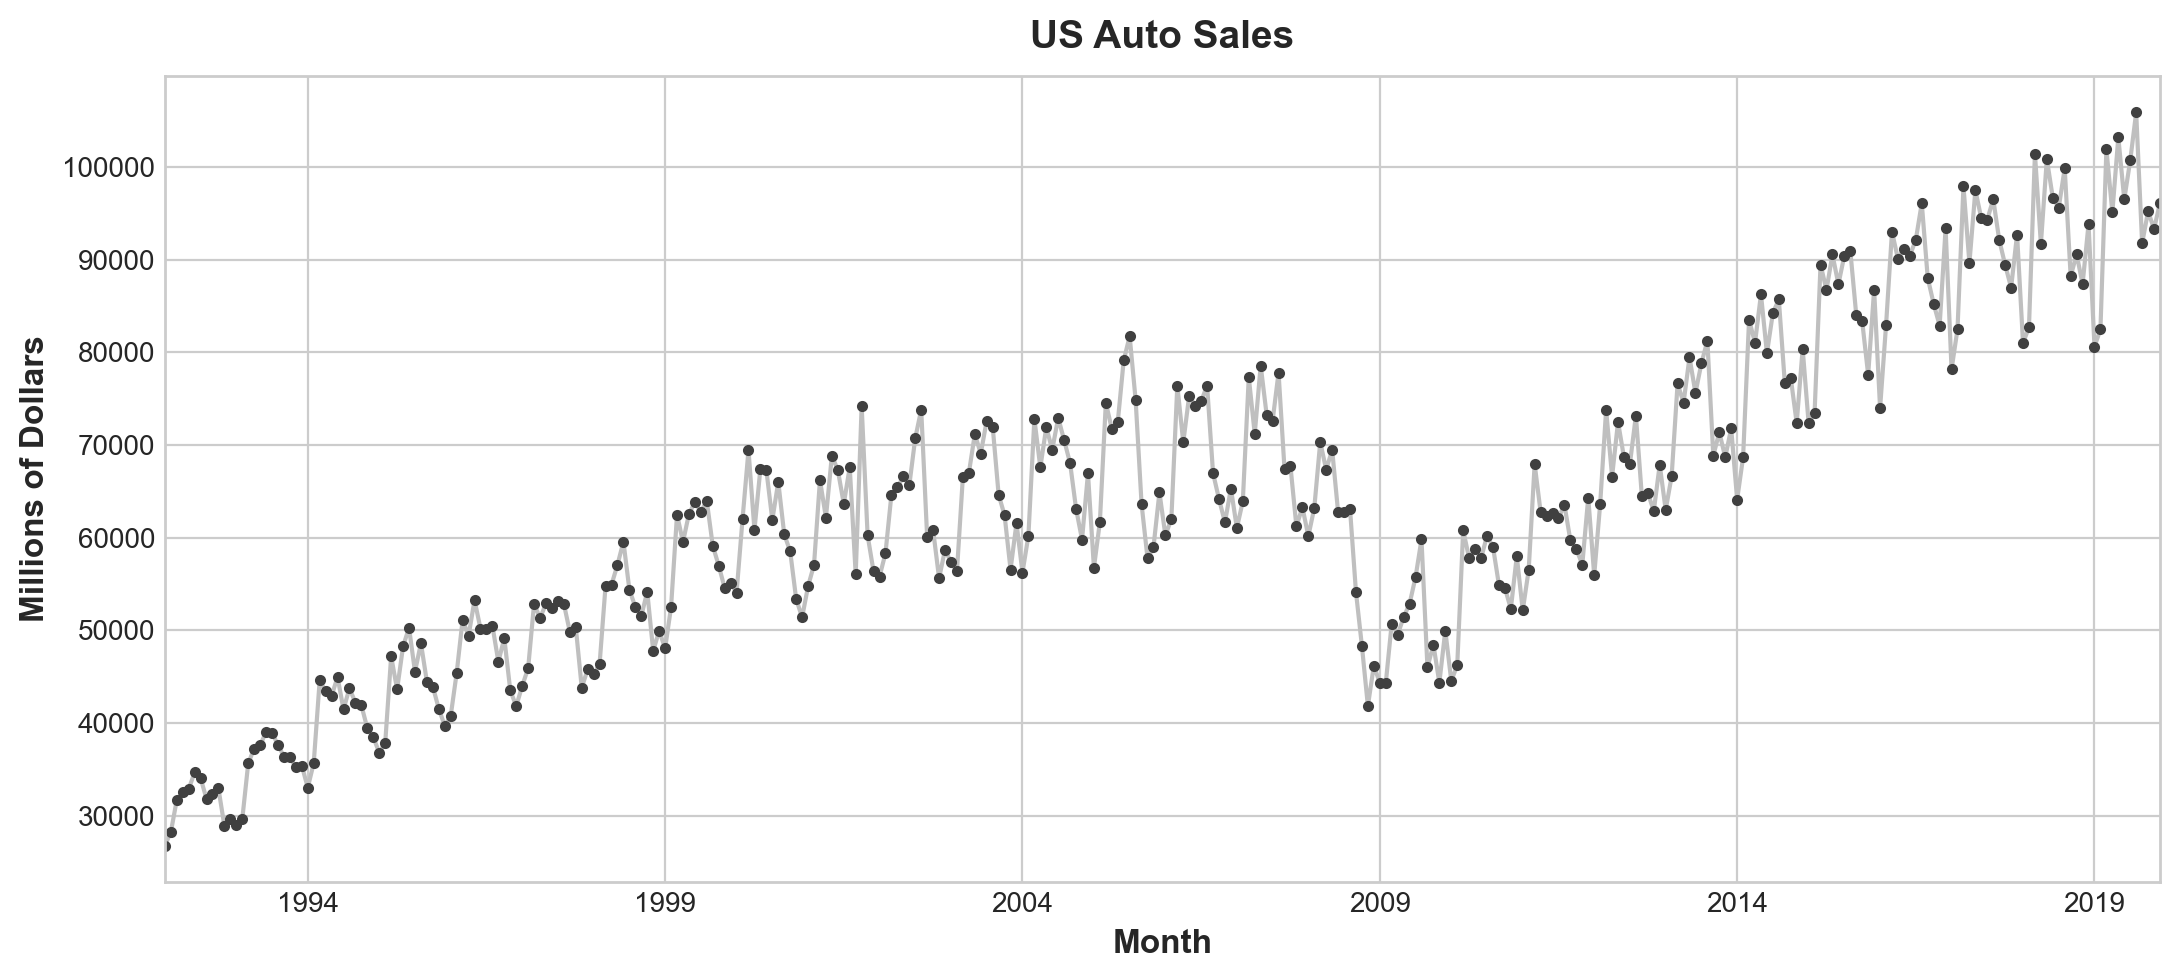

In [98]:
ax = auto_sales.plot(**plot_params,
                    title='US Auto Sales',
                    ylabel='Millions of Dollars')

## Create moving range for auto sales

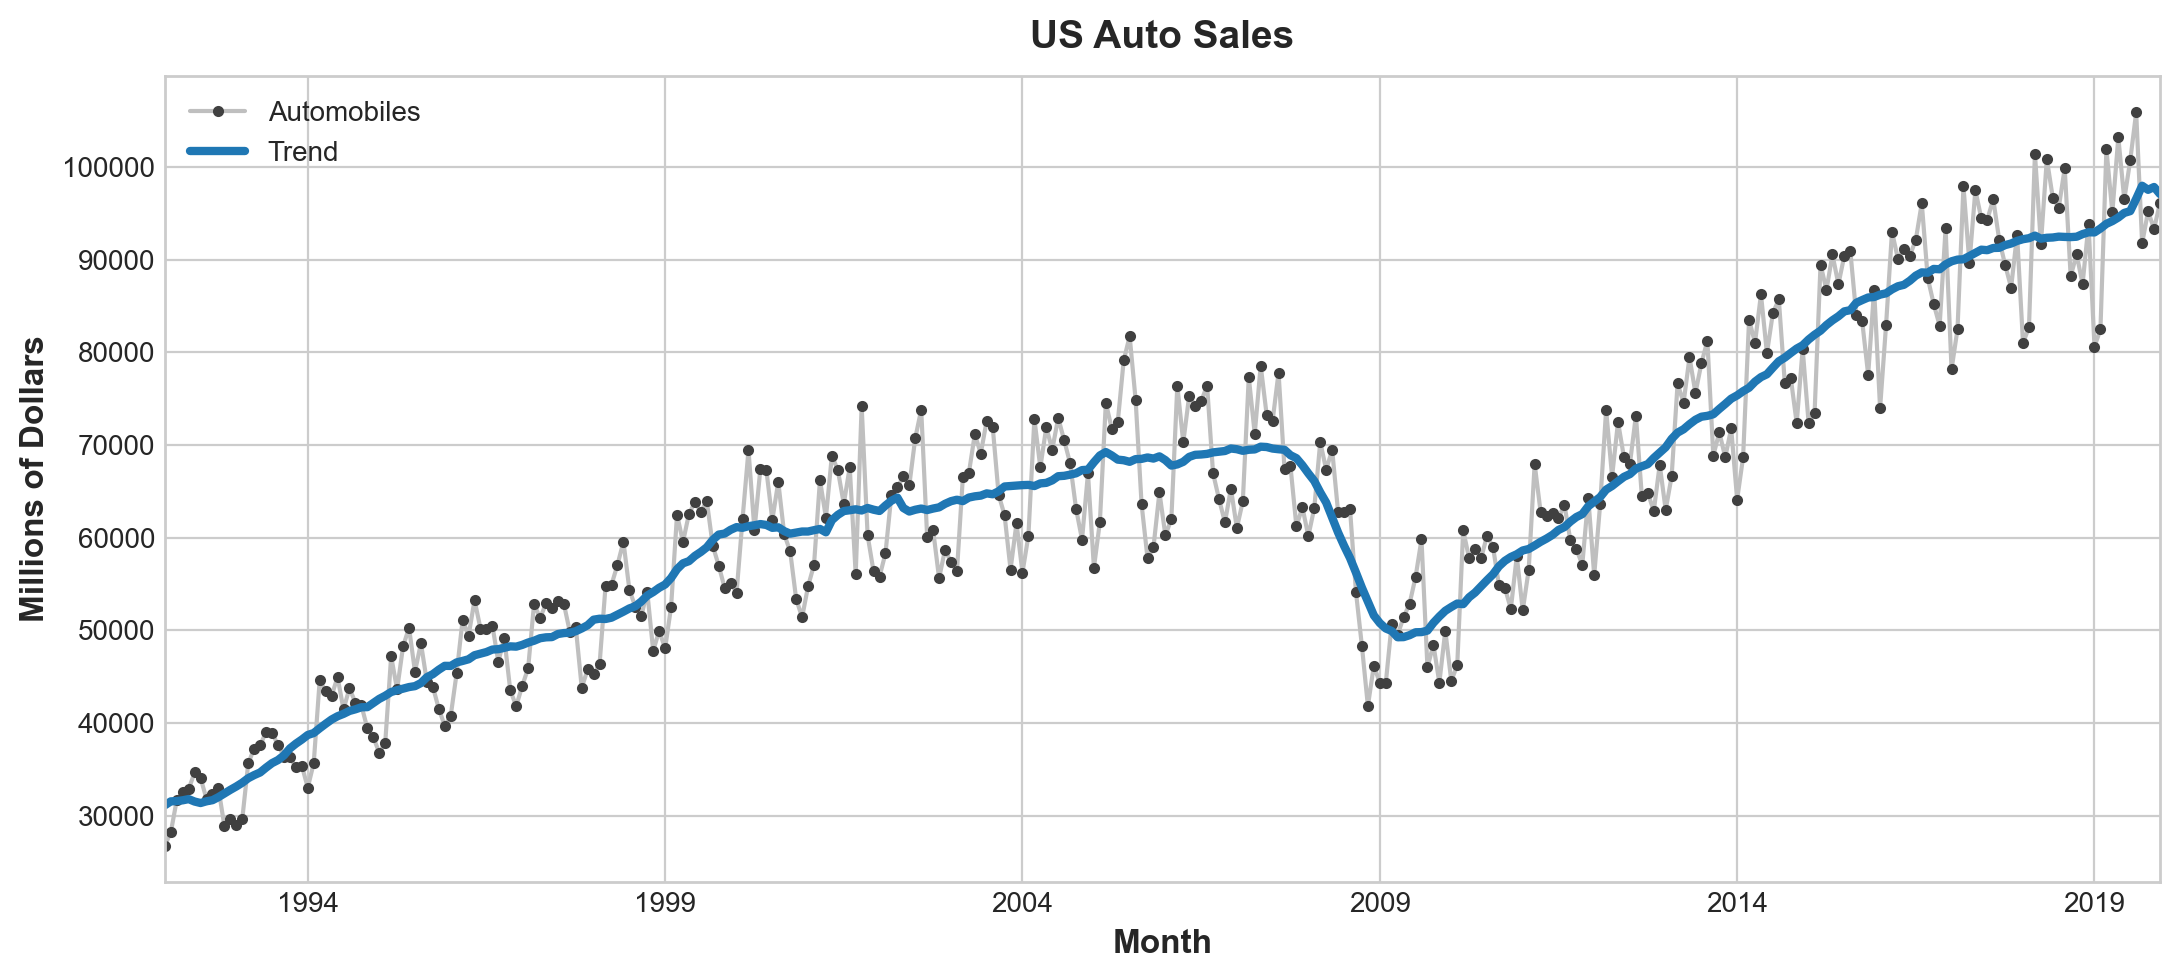

In [104]:
auto_moving_average = auto_sales.rolling(
    window=12,
    center=True,
    min_periods=6
    ).mean()

# Plot food_sales and food_sales moving range together
ax = auto_sales.plot(**plot_params,
                    title='US Auto Sales',
                    ylabel='Millions of Dollars')
auto_moving_average.plot(ax=ax, linewidth=3, label='Trend')
ax.legend();

## Create the time dummy 

In [122]:
dp = DeterministicProcess(
    index=auto_sales.index,
    constant=True,
    order=3)

# in_sample creates features for the dates given in the index argument 
X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed
Month,,,,
1992-01,1.0,1.0,1.0,1.0
1992-02,1.0,2.0,4.0,8.0
1992-03,1.0,3.0,9.0,27.0
1992-04,1.0,4.0,16.0,64.0
1992-05,1.0,5.0,25.0,125.0


In [123]:
y = auto_sales

model = LinearRegression(fit_intercept=False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Month
1992-01     25086.565217
1992-02     25734.665829
1992-03     26375.088059
1992-04     27007.879007
1992-05     27633.085774
               ...      
2019-08    102357.863176
2019-09    103036.803835
2019-10    103723.656322
2019-11    104418.467736
2019-12    105121.285179
Freq: M, Length: 336, dtype: float64

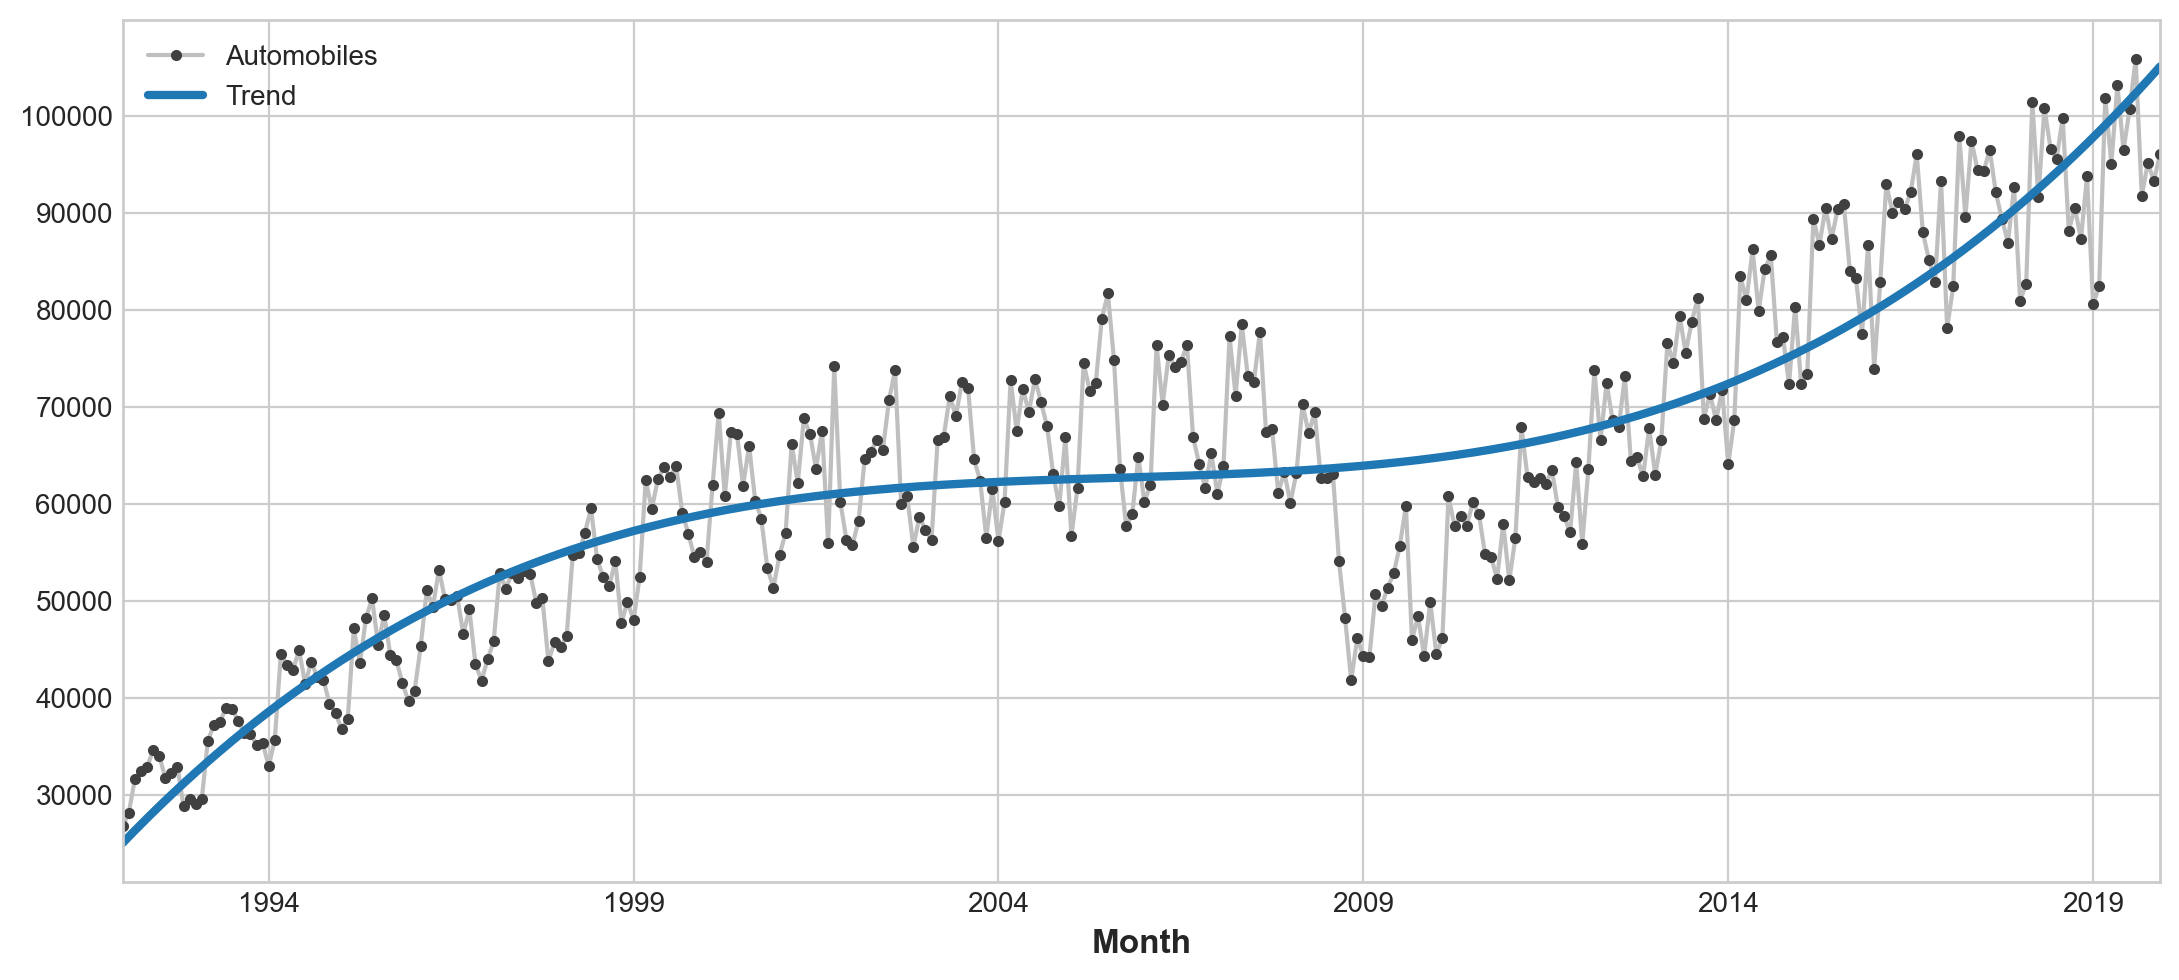

In [124]:
# Plot the auto sales with the LinearRegression model
# The model is set to an order of 2 meaning it is quadratic (parabola)
ax = auto_sales.plot(**plot_params)
y_pred.plot(ax=ax,
           linewidth=3,
           label='Trend')
ax.legend();

The polynomial order 3 is not a perfect fit but it is a starting point.

## Create the forecast

In [125]:
X = dp.out_of_sample(steps=30)
X.head()

,const,trend,trend_squared,trend_cubed
2020-01,1.0,337.0,113569.0,38272753.0
2020-02,1.0,338.0,114244.0,38614472.0
2020-03,1.0,339.0,114921.0,38958219.0
2020-04,1.0,340.0,115600.0,39304000.0
2020-05,1.0,341.0,116281.0,39651821.0


In [126]:
# Create the y_fore series
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

2020-01    105832.155749
2020-02    106551.126549
2020-03    107278.244677
2020-04    108013.557234
2020-05    108757.111321
Freq: M, dtype: float64

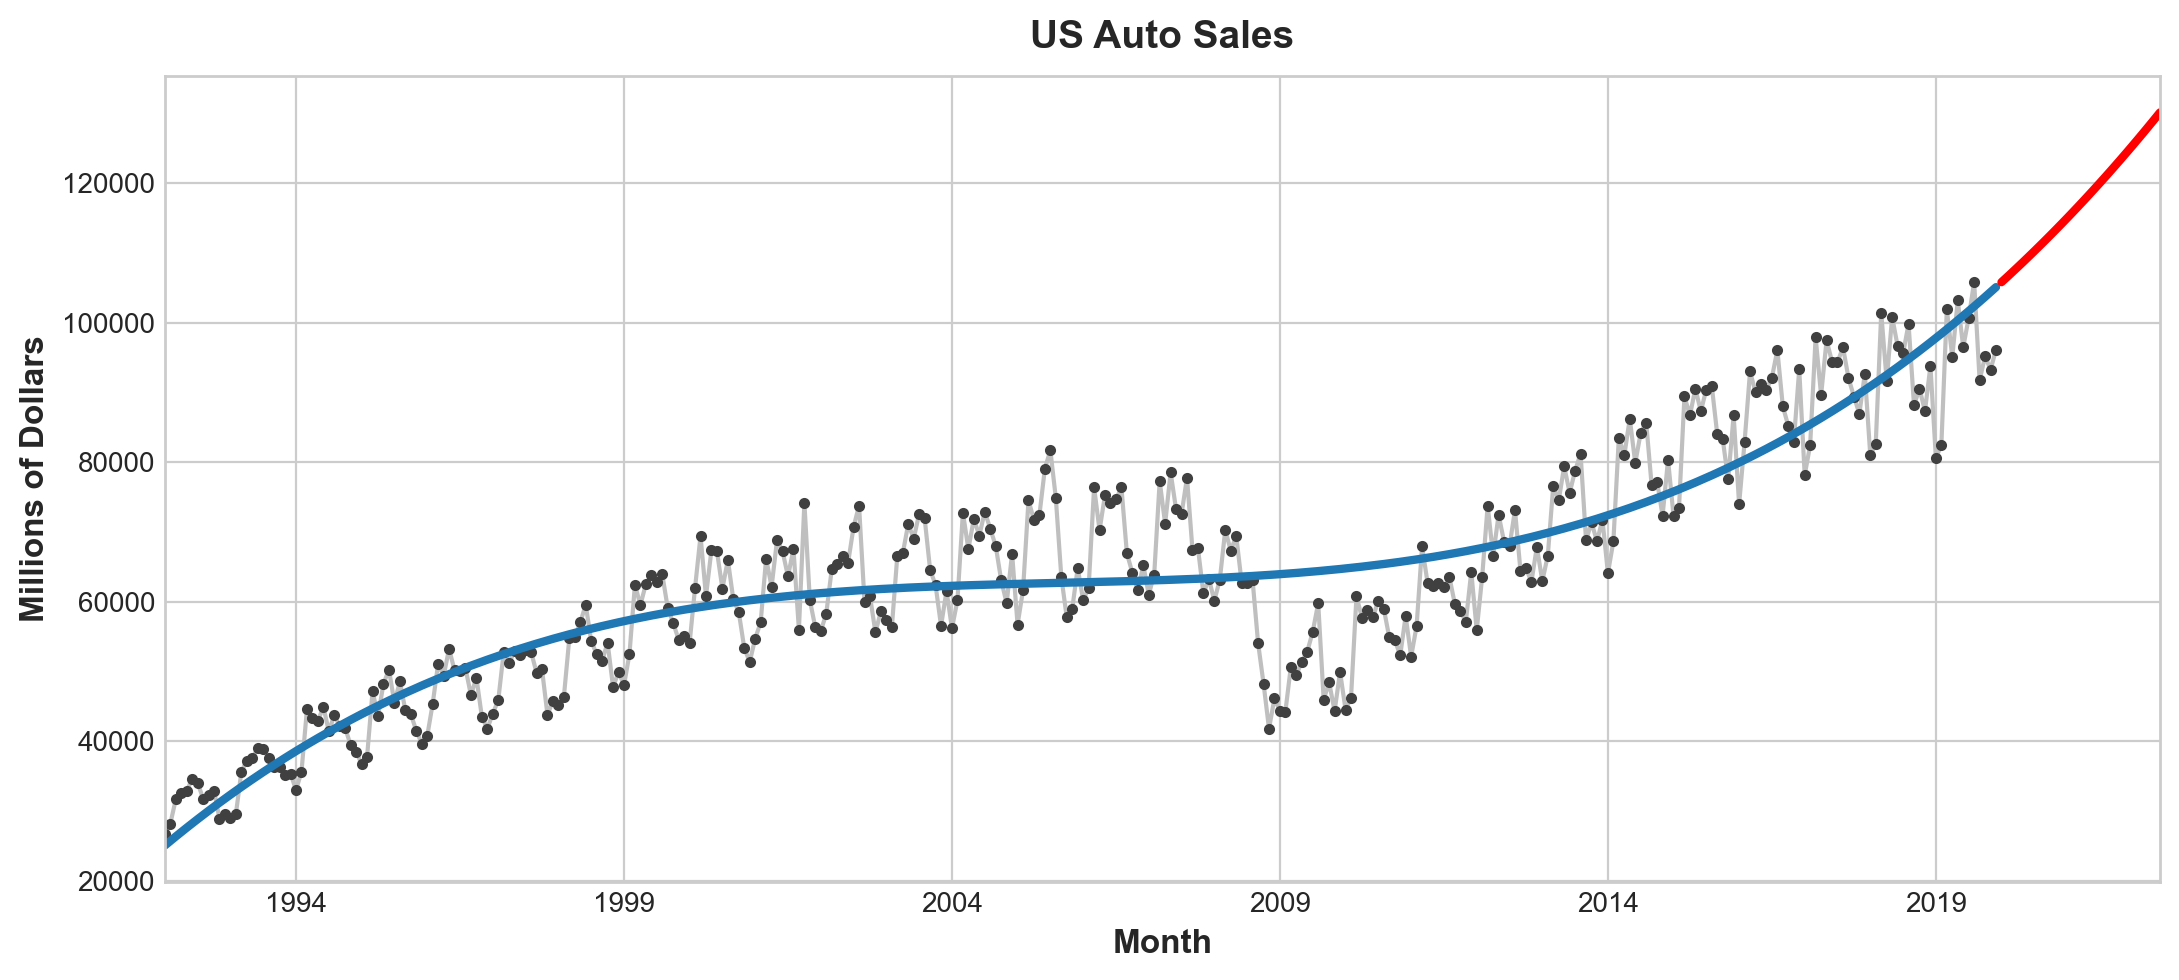

In [129]:
ax = auto_sales.plot(**plot_params,
                    title='US Auto Sales',
                    ylabel='Millions of Dollars')
ax = y_pred.plot(ax=ax,
                linewidth=3,
                label='Trend')
ax = y_fore.plot(ax=ax,
                linewidth=3,
                label='Trend Forecast',
                color='red')

This forcast is driven by a 3rd order polynomial that attempts to account for the drop in sales due to the financial crisis in 2008. This makes it a poor forecast. To address this we truncate the data so we start in 2009. 

## Auto sales starting in 2009

In [132]:
auto_sales_2009 = auto_sales["2009-01":]
auto_sales_2009

Month
2009-01     44342
2009-02     44283
2009-03     50742
2009-04     49549
2009-05     51414
            ...  
2019-08    105884
2019-09     91758
2019-10     95219
2019-11     93303
2019-12     96137
Freq: M, Name: Automobiles, Length: 132, dtype: int64

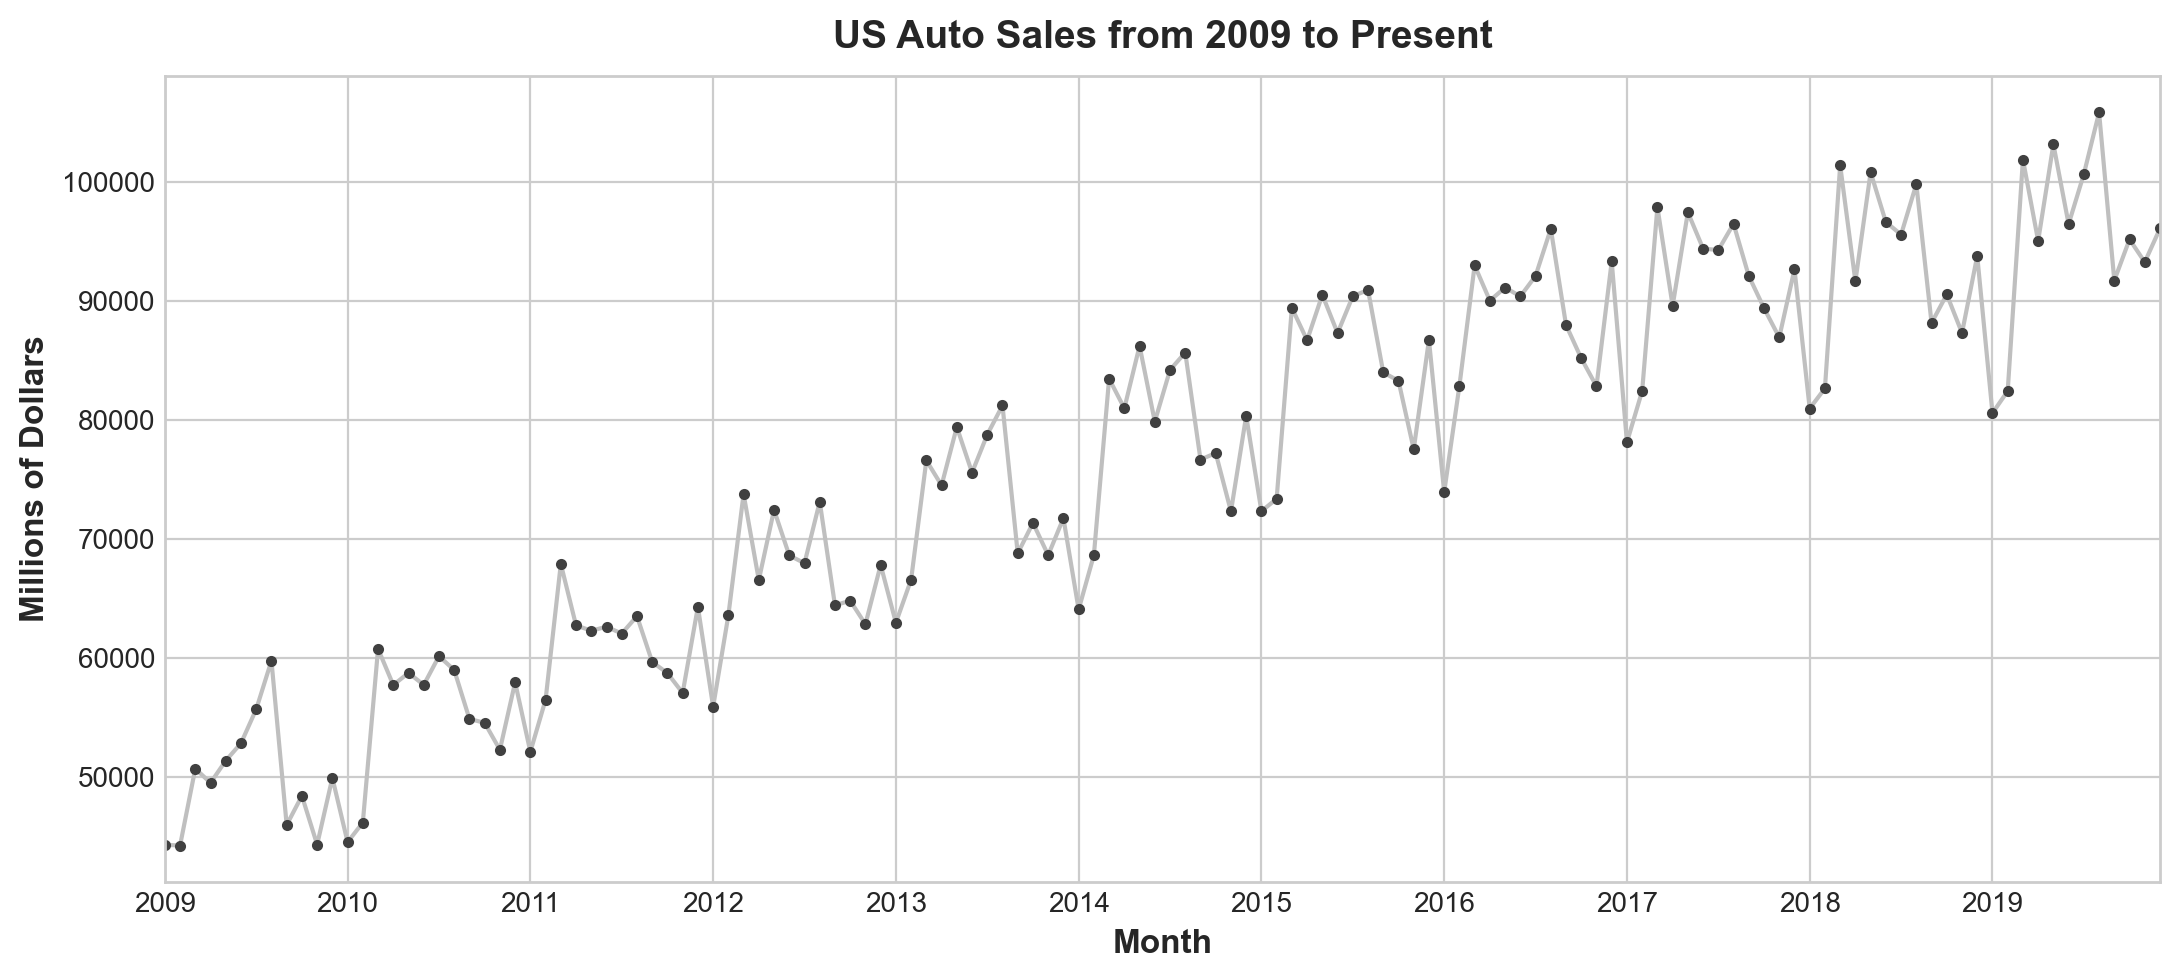

In [134]:
# Plot the data 
ax = auto_sales_2009.plot(**plot_params,
                         title='US Auto Sales from 2009 to Present',
                         ylabel='Millions of Dollars')

## Create the moving average

In [137]:
AS_2009_moving_range = auto_sales_2009.rolling(
    window=12,
    center=True,
    min_periods=6
).mean()
AS_2009_moving_range

Month
2009-01    48867.833333
2009-02    49848.571429
2009-03    51093.875000
2009-04    50529.111111
2009-05    50321.900000
               ...     
2019-08    96563.818182
2019-09    97973.300000
2019-10    97534.000000
2019-11    97839.500000
2019-12    97071.857143
Freq: M, Name: Automobiles, Length: 132, dtype: float64

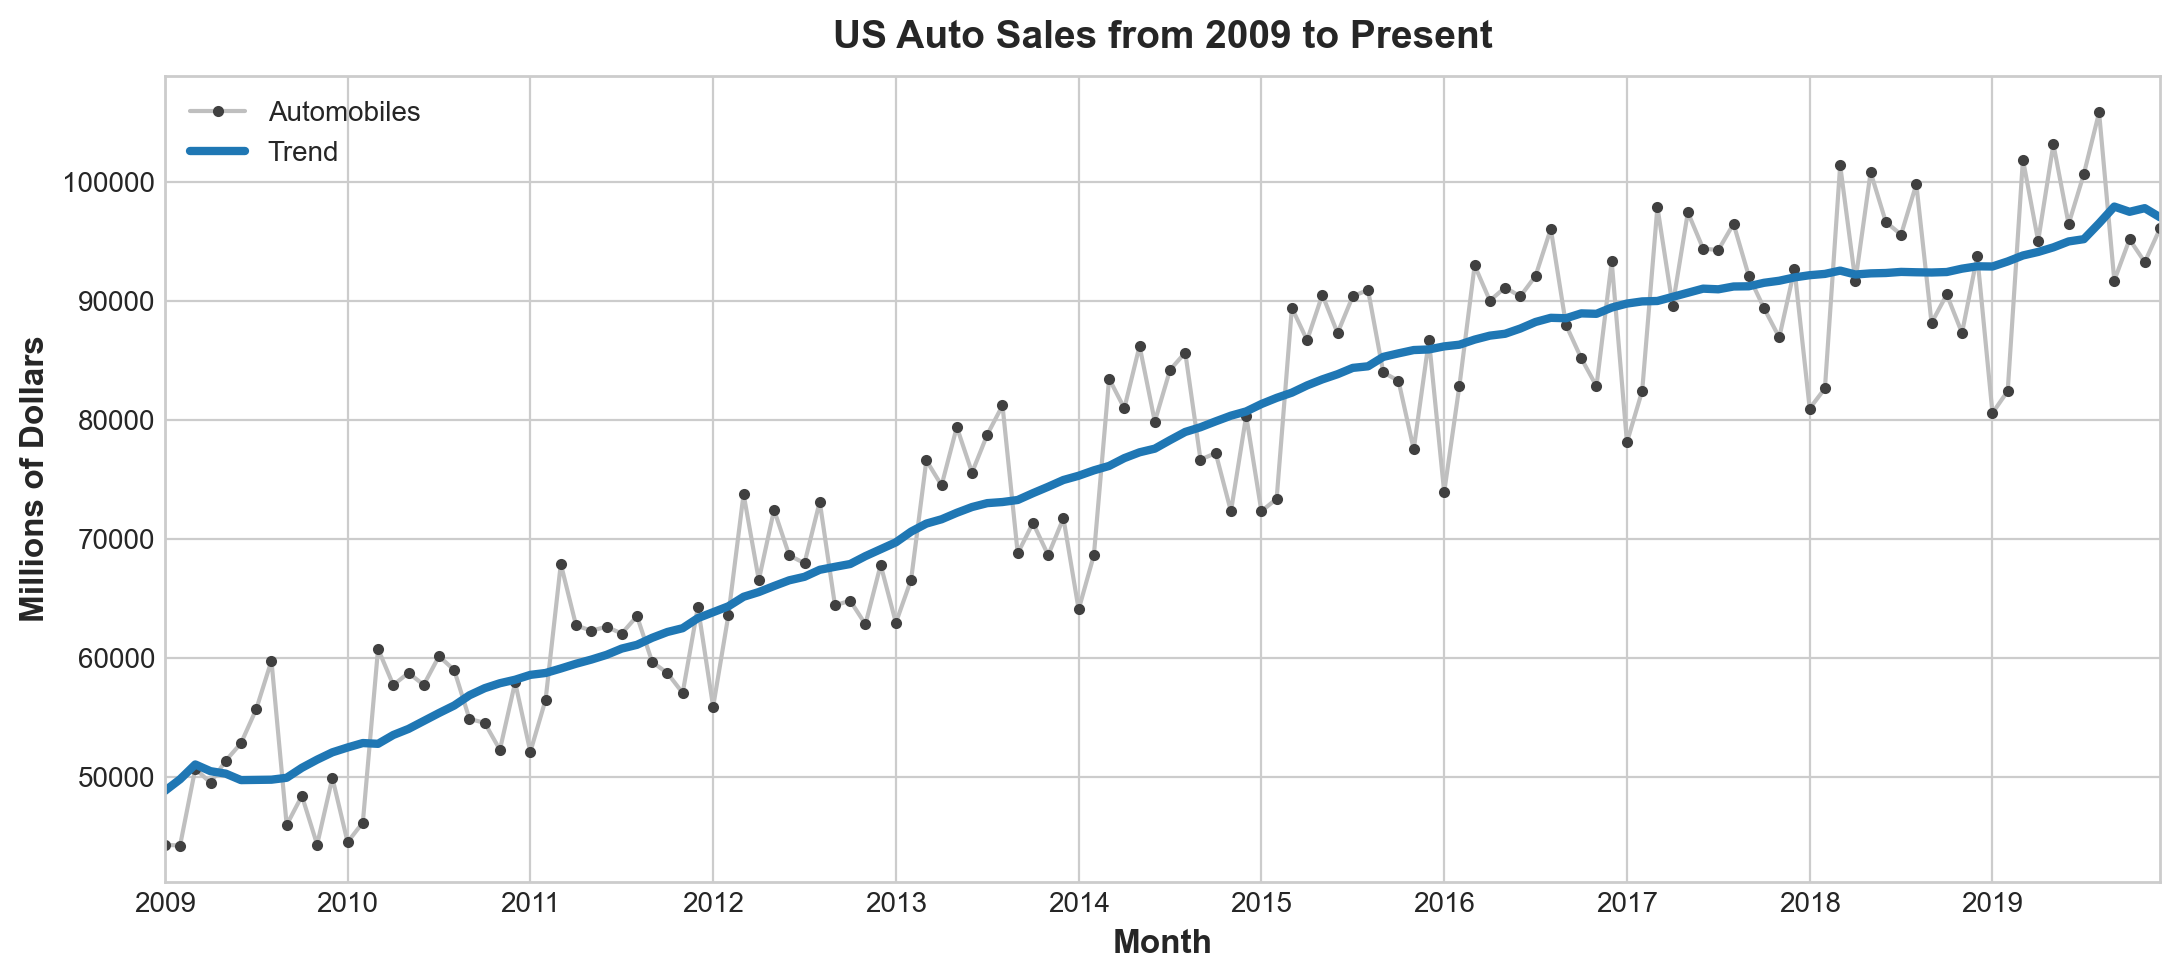

In [140]:
# Plot the moving range
ax = auto_sales_2009.plot(**plot_params,
                         title='US Auto Sales from 2009 to Present',
                         ylabel='Millions of Dollars')
AS_2009_moving_range.plot(ax=ax,
                         linewidth=3,
                         label='Trend')
ax.legend();

A second order polynomial is likely to be a good fit.

## Engineer the time dummy

In [141]:
dp = DeterministicProcess(
    index=auto_sales_2009.index,
    constant=True,
    order=2,
    drop=True)

# in_sample creates features for the dates given in the index argument
X = dp.in_sample()
X.head()

,const,trend,trend_squared
Month,,,
2009-01,1.0,1.0,1.0
2009-02,1.0,2.0,4.0
2009-03,1.0,3.0,9.0
2009-04,1.0,4.0,16.0
2009-05,1.0,5.0,25.0


In [143]:
y = auto_sales_2009

model = LinearRegression(fit_intercept=False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

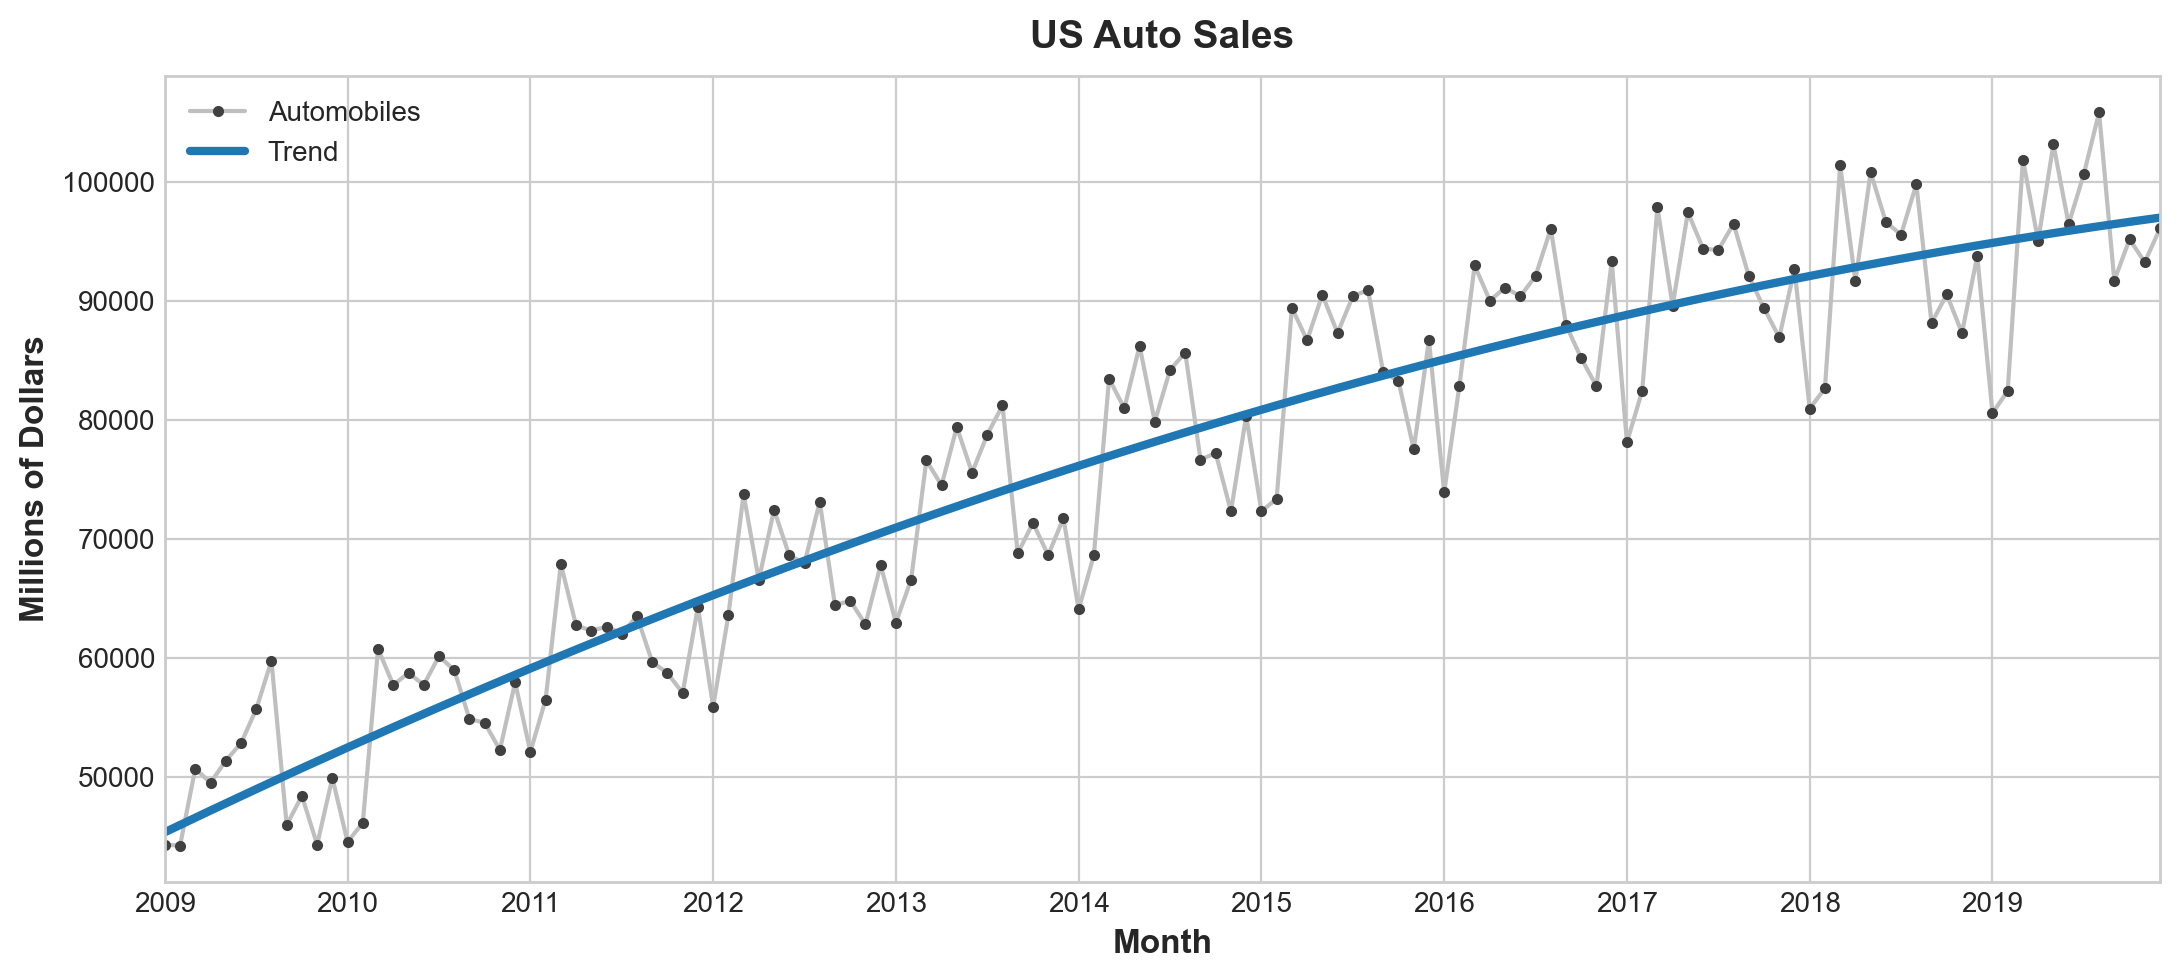

In [145]:
# Plot the 2009 auto sales data
ax = auto_sales_2009.plot(**plot_params,
                         title='US Auto Sales',
                         ylabel='Millions of Dollars')
y_pred.plot(ax=ax,
           linewidth=3,
           label="Trend")
ax.legend();

This is a much better fit than the 3rd order polynomial previously used.

## Make a forecast

In [146]:
X = dp.out_of_sample(steps=30)
X.head()

,const,trend,trend_squared
2020-01,1.0,133.0,17689.0
2020-02,1.0,134.0,17956.0
2020-03,1.0,135.0,18225.0
2020-04,1.0,136.0,18496.0
2020-05,1.0,137.0,18769.0


In [147]:
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

2020-01    97218.415043
2020-02    97388.210342
2020-03    97554.655615
2020-04    97717.750862
2020-05    97877.496083
Freq: M, dtype: float64

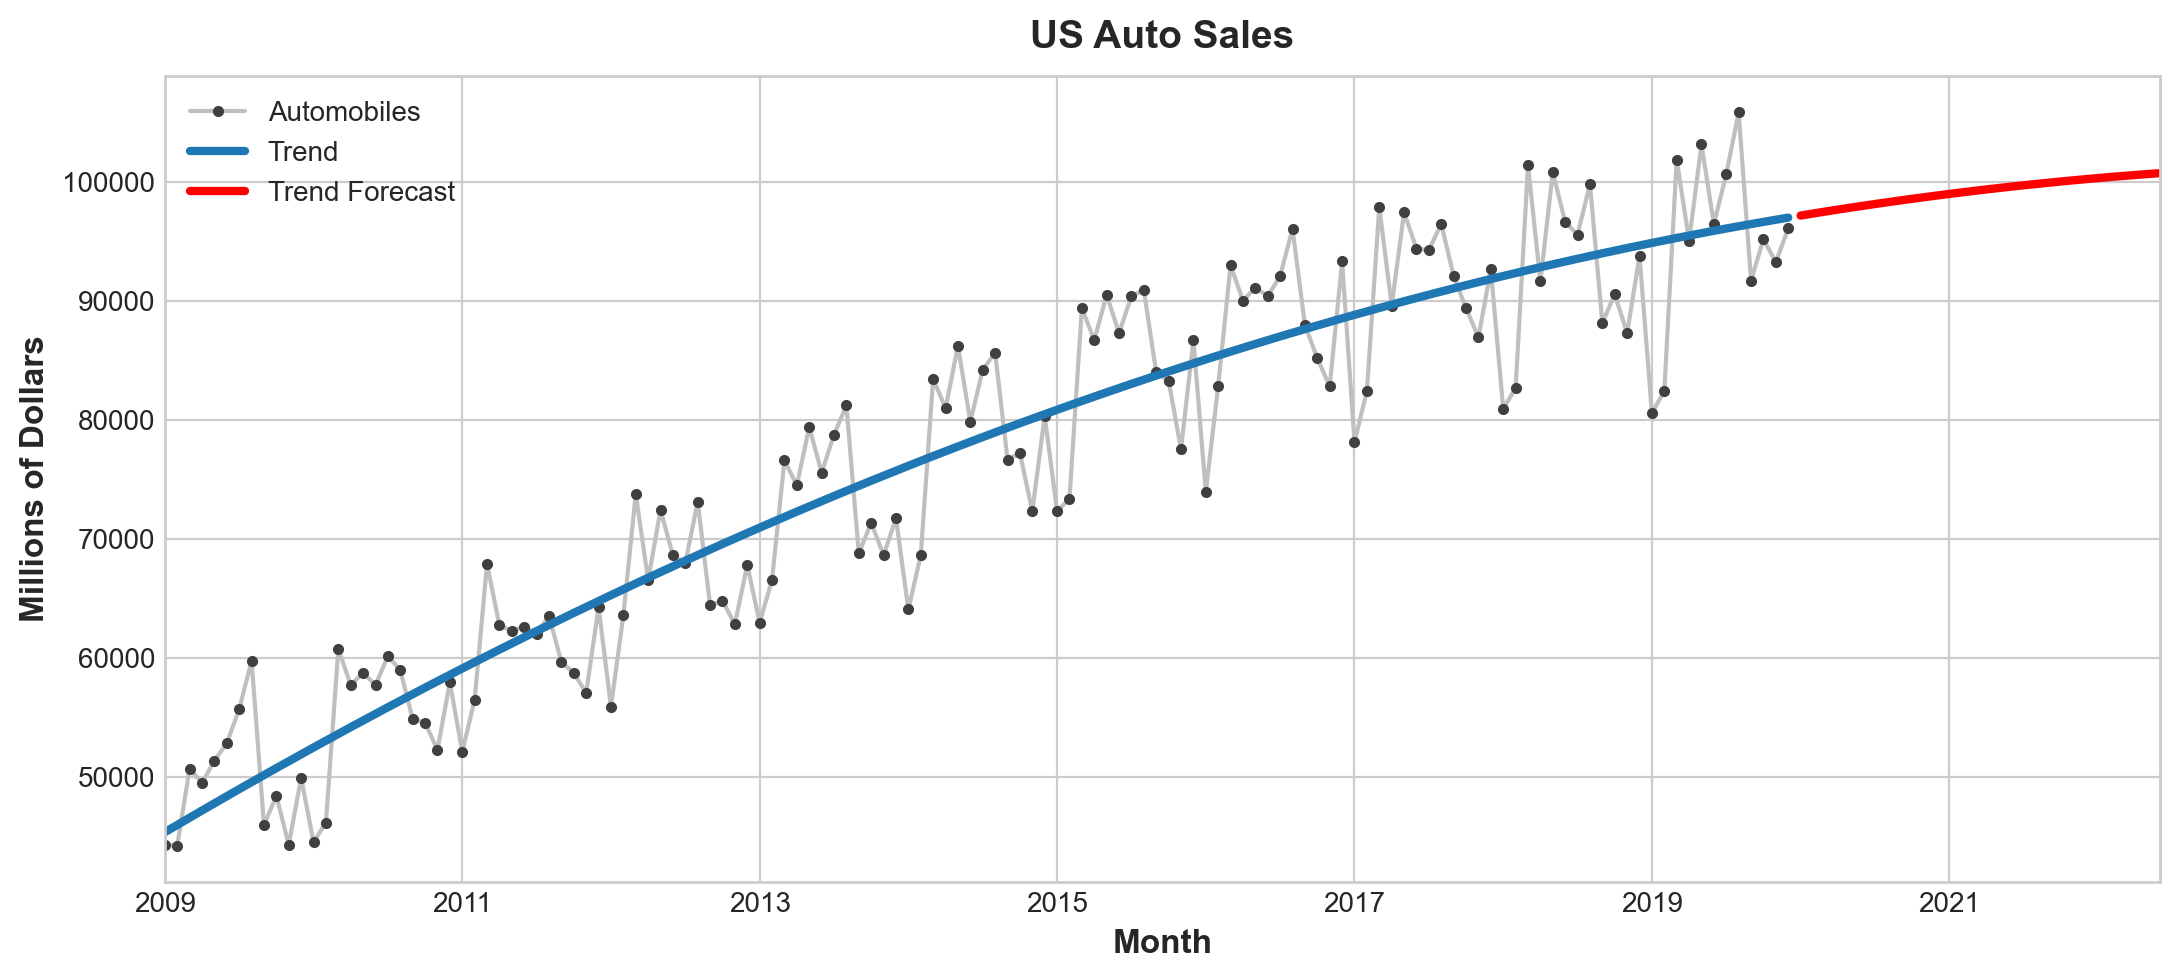

In [148]:
# Plot the data with the forecast
ax = auto_sales_2009.plot(**plot_params,
                         title='US Auto Sales',
                         ylabel='Millions of Dollars')
y_pred.plot(ax=ax,
           linewidth=3,
           label="Trend")
y_fore.plot(ax=ax,
           linewidth=3,
           label='Trend Forecast',
           color='red')
ax.legend();